# Tweets analyzer.

#### This Notebook analyzes tweets to from individuals to a company. The please note:
##### 1. The main goal of this notebook is to analyze questions and reviews left by users for company's therefore to get more relevant data I have excluded tweets with attachments and only included tweets which are not replies to tweets or retweets.

#### 2. The data has been scrapped from twitter directly using octoparse 8. This data is from the periods between 01/01/2021 to 31/12/2021.

In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install spacy-langdetect
!pip install contractions
!pip install gensim
!pip install pyLDAvis

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip



import pandas as pd
import regex as re
import plotly.express as px
import numpy as np
import datetime
import spacy
import nltk
import contractions
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.enable_notebook()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

     |████████████████████████████████| 12.0 MB 8.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 998 kB 8.4 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993431 sha256=ee08d149f37c4945fc15f7121468d9b4de2e7af003bc865404c456f7a894417f
  Stored in directory: /root/.cache/pip/wheels/89/79/3b/9885ae7f4308f73c514f96d8574d40d7d8173a27731b674013
Successfully built langdetect
     |████████████████████████████████| 284 kB 8.2 MB/s 
     |████████████████████████████████| 106 kB 72.5 MB/s 
     |████████████████████████████████| 1.7 MB 8.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=118f84a5ee74bc3eed0a6b5afc5a34f44a9aef569d2bd08f4c7facd

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [117]:
df = pd.read_csv('/content/kplc_twitter_2021.csv')

In [118]:
def convertCountToInt(count):
    if(isinstance(count,str) and count[-1].lower() in ['k','m']):
        multiplier = 1000  if count[-1].lower() == 'k' else 1000000
        count = float(count[:len(count)-1]) * multiplier
    return int(count)

def cleanTweet1(tweet):
    pattern = r'\n'
    return re.sub(pattern,' ',tweet)

In [119]:
#converting comments, reshare and likes to int
df.fillna(0,inplace=True)

intColumns = ['comments','reshare','likes']

for column in intColumns:
    df[column] = df[column].apply(convertCountToInt);
    


In [120]:
#we'll remove next line tags to cleanup the data
df['tweet_cleaned'] = df['tweet'].apply(cleanTweet1)

#checking whether there are any null columns
df.isnull().sum()

Name             0
handle           0
Time             0
tweet            0
comments         0
reshare          0
likes            0
tweet_cleaned    0
dtype: int64

In [121]:
#we'll remove the name column since we don't need it for the analysis
df.drop(['Name'],axis=1,inplace = True)

df.sample(10, random_state=10)

,handle,Time,tweet,comments,reshare,likes,tweet_cleaned
1636,@seanC_1O,2021-05-04T15:44:36.000Z,Tangu Friday KPLC wamekataa kutengeneza stima ...,1,1,2,Tangu Friday KPLC wamekataa kutengeneza stima ...
1126,@amanialvinn,2021-07-28T09:50:08.000Z,#kplccustomercare \n@KenyaPower_Care\n \n@Keny...,1,0,0,#kplccustomercare @KenyaPower_Care @KenyaPo...
1583,@lydssham,2021-05-12T15:05:01.000Z,"Dear Customer,Your complaint for prepaid meter...",0,0,1,"Dear Customer,Your complaint for prepaid meter..."
1911,@kakayoung01,2021-04-08T15:00:10.000Z,Hello \n@KenyaPower_Care\n \n@KenyaPower\n fo...,0,0,0,Hello @KenyaPower_Care @KenyaPower for th...
404,@ansibuor,2021-11-16T12:53:36.000Z,"Now that we are talking about fraudsters, \n@K...",1,3,10,"Now that we are talking about fraudsters, @Ke..."
1305,@injilipaul,2021-06-27T08:39:04.000Z,No power! Since Saturday 26th june mid morning...,1,0,0,No power! Since Saturday 26th june mid morning...
822,@hingittah,2021-09-15T18:42:42.000Z,"....with fuel prices up, will our hydroelectri...",0,0,0,"....with fuel prices up, will our hydroelectri..."
707,@reggaeholic_,2021-10-06T14:28:05.000Z,"Sijawahi ona \n@KenyaPower_Care\n , \n@KenyaPo...",0,0,0,"Sijawahi ona @KenyaPower_Care , @KenyaPower..."
2189,@MosesNtabo,2021-03-10T07:28:56.000Z,I hope this >> \n@sos_kibe_\n not \n@KenyaPow...,1,0,0,I hope this >> @sos_kibe_ not @KenyaPower ...
1214,@KituiOnline,2021-07-11T17:26:22.000Z,Kitui: There are trees interfering with powerl...,0,0,2,Kitui: There are trees interfering with powerl...


In [122]:
# we need to format the date in a more analsis friendly way
df['Month'] = pd.DatetimeIndex(df['Time']).month
df['Day'] = pd.DatetimeIndex(df['Time']).day
df['Time'] = pd.DatetimeIndex(df['Time']).time

df.sample(10, random_state=7)

,handle,Time,tweet,comments,reshare,likes,tweet_cleaned,Month,Day
2640,@2FingersKenya,16:38:06,Hi \n@KenyaPower\n \n@KenyaPower_Care\n power ...,1,0,0,Hi @KenyaPower @KenyaPower_Care power outa...,1,13
1673,@johnmark254,18:08:30,#pawasawa \n@KenyaPower\n \n@KenyaPower_Care...,1,0,0,#pawasawa @KenyaPower @KenyaPower_Care ...,4,30
732,@Birchok_H,18:40:08,Dear \n@KenyaPower_Care\n kindly assist with t...,1,0,0,Dear @KenyaPower_Care kindly assist with tok...,10,3
267,@AllanKamau12,11:08:40,Hello \n@KenyaPower_Care\n \n@KenyaPower\n we...,1,0,0,Hello @KenyaPower_Care @KenyaPower we exp...,11,29
450,@Mercymunyingi,07:38:51,#kplccustomercare \n@kenyapower\n \n@KenyaPowe...,1,1,0,#kplccustomercare @kenyapower @KenyaPower_C...,11,9
2586,@Mca_Trickyy,10:30:05,Dear \n@KenyaPower\n \n@KenyaPower_Care\n same...,1,0,0,Dear @KenyaPower @KenyaPower_Care same 'bl...,1,24
412,@ItsGasheri,14:16:01,Oyaaaaaaa \n@KenyaPower_Care\n \n@KenyaPower\n...,2,0,0,Oyaaaaaaa @KenyaPower_Care @KenyaPower No ...,11,15
2677,@MichKatami,10:35:18,"""Mwangaza wamlika, nchi ya songa Mbele...""\n\n...",1,0,0,"""Mwangaza wamlika, nchi ya songa Mbele..."" ""P...",1,10
219,@stevemusilih,10:11:15,Good afternoon \n@KenyaPower\n \n@KenyaPower_C...,1,0,0,Good afternoon @KenyaPower @KenyaPower_Care...,12,3
2180,@ihaji_marilu,16:49:03,It's so unfortunate for a busy street like Kee...,0,1,0,It's so unfortunate for a busy street like Kee...,3,11


In [123]:


import spacy
from spacy_langdetect import LanguageDetector
LanguageClassifier = spacy.load('en')
LanguageClassifier.add_pipe(LanguageDetector(), name='language_detector', last=True)

In [124]:
#since we have tweets in both swahili and english, we will first categorize them into the respective language.
df['language'] = df['tweet'].apply(lambda tweet: 'Swahili' if LanguageClassifier(tweet)._.language['language']== 'sw' else 'English')

In [125]:
df.sample(10, random_state=7)

,handle,Time,tweet,comments,reshare,likes,tweet_cleaned,Month,Day,language
2640,@2FingersKenya,16:38:06,Hi \n@KenyaPower\n \n@KenyaPower_Care\n power ...,1,0,0,Hi @KenyaPower @KenyaPower_Care power outa...,1,13,English
1673,@johnmark254,18:08:30,#pawasawa \n@KenyaPower\n \n@KenyaPower_Care...,1,0,0,#pawasawa @KenyaPower @KenyaPower_Care ...,4,30,English
732,@Birchok_H,18:40:08,Dear \n@KenyaPower_Care\n kindly assist with t...,1,0,0,Dear @KenyaPower_Care kindly assist with tok...,10,3,English
267,@AllanKamau12,11:08:40,Hello \n@KenyaPower_Care\n \n@KenyaPower\n we...,1,0,0,Hello @KenyaPower_Care @KenyaPower we exp...,11,29,English
450,@Mercymunyingi,07:38:51,#kplccustomercare \n@kenyapower\n \n@KenyaPowe...,1,1,0,#kplccustomercare @kenyapower @KenyaPower_C...,11,9,English
2586,@Mca_Trickyy,10:30:05,Dear \n@KenyaPower\n \n@KenyaPower_Care\n same...,1,0,0,Dear @KenyaPower @KenyaPower_Care same 'bl...,1,24,English
412,@ItsGasheri,14:16:01,Oyaaaaaaa \n@KenyaPower_Care\n \n@KenyaPower\n...,2,0,0,Oyaaaaaaa @KenyaPower_Care @KenyaPower No ...,11,15,English
2677,@MichKatami,10:35:18,"""Mwangaza wamlika, nchi ya songa Mbele...""\n\n...",1,0,0,"""Mwangaza wamlika, nchi ya songa Mbele..."" ""P...",1,10,Swahili
219,@stevemusilih,10:11:15,Good afternoon \n@KenyaPower\n \n@KenyaPower_C...,1,0,0,Good afternoon @KenyaPower @KenyaPower_Care...,12,3,English
2180,@ihaji_marilu,16:49:03,It's so unfortunate for a busy street like Kee...,0,1,0,It's so unfortunate for a busy street like Kee...,3,11,English


In [126]:
#Lets see the count of kiswahili vs English reviews
df['language'].value_counts()

fig = px.bar(df, 
             y=df['language'].value_counts().values, 
             x=df['language'].value_counts().index,
             title = "Counts of tweets by language",
            labels={"x":"Language","y":"Number of tweets"})
fig.show()


In [127]:
#Now let's get a feel of the average length of a tweet

df['tweetLength'] = df['tweet'].apply(lambda tweet:len(tweet))
fig = px.box(df,y='tweetLength',title="Average tweet length")
fig.show()

In [128]:
#lets get to see the distribution of the tweets over different months

fig = px.bar(df,
             y=df['Month'].value_counts().values, 
             x=df['Month'].value_counts().index,
             title = "Counts of tweets by Month",
            labels={"x":"Month","y":"Number of tweets"})
fig.show()

In [129]:
#Getting distribution on accordance to hour of the day

df['hour'] = df['Time'].apply(lambda time: time.hour)

fig = px.bar(df,
             y=df['hour'].value_counts().values, 
             x=df['hour'].value_counts().index,
             title = "Counts of tweets by Month",
            labels={"x":"Hour","y":"Number of tweets"},
            )
fig.show()

#### From the initial EDA we have the following info:
#### 1. The tweets are multilingual with the larger percentage being on English and the lesser is Kiswahili.
#### 2. The average length of a tweet is 148 characters which tells us that people don't write long tweets for this company
#### 3. The first quarter of the year saw relatively more tweets than the other quarters.
#### 4. Most people tweet in the morning hours (6am - 9am) and in the afternoon (2pm - 6pm)

#### We will proceed to analyze the English reviews since they are more as compared to the English once and we also have more resources for English compared to swahili

In [130]:
#We'll first of all get our subset of the English reviews

df_english = df[df['language'] == 'English'].copy()
df_english.drop(['comments','reshare','likes','Time','language'], axis = 1, inplace= True)
df_english.sample(10, random_state=9)

,handle,tweet,tweet_cleaned,Month,Day,tweetLength,hour
1371,@OfKenyah,Be serious \n@KenyaPower\n \n@KenyaPower_Care\...,Be serious @KenyaPower @KenyaPower_Care ho...,6,14,174,8
1331,@moir603,"KPLC disrupts power working okay, pretends to ...","KPLC disrupts power working okay, pretends to ...",6,22,225,17
1821,@CoachBill254,Hey \n@KenyaPower_Care\n \n@KenyaPower\n \n@Ke...,Hey @KenyaPower_Care @KenyaPower @KenyaPo...,4,17,208,8
758,@donsabwa,#kplccustomercare \n@KenyaPower_Care\n \n@Keny...,#kplccustomercare @KenyaPower_Care @KenyaPo...,9,28,277,12
914,@NyaksOmogambi,Is monopoly likely to end \n@KenyaPower\n? \n@...,Is monopoly likely to end @KenyaPower ? @Ken...,8,29,109,9
825,@nyamweyaJ,So wakubwa mlistrike and refuse to issue me w...,So wakubwa mlistrike and refuse to issue me w...,9,15,117,17
1936,@ThankGodNjugush,Mt No...37228261287\nLess than 48 hours Alread...,Mt No...37228261287 Less than 48 hours Already...,4,6,132,16
694,@IAMRAPCHA,Hi \n@KenyaPower\n \n@KenyaPower_Care\n Mpesa...,Hi @KenyaPower @KenyaPower_Care Mpesa pay...,10,7,97,8
2257,@Lwandejoe,Watu wa South B tunaumia. No electricity since...,Watu wa South B tunaumia. No electricity since...,2,28,87,12
2078,@Itscollins_ke,Hello \n@KenyaPower_Care\n (\n@KenyaPower\n)La...,Hello @KenyaPower_Care ( @KenyaPower )Large ...,3,25,282,14


In [131]:
#Lets no clean the data to so a more indepth analysis

#removing contractions, special charaters
def cleanTweet2(tweet):
  tweet = tweet.lower()
  tweet = [contractions.fix(word) for word in tweet.split()]
  tweet = ' '.join(map(str, tweet)) 
  tweet = re.sub('[^\w\d\s]+','',tweet)
  return tweet


df_english['tweet_cleaned2'] = df_english['tweet_cleaned'].apply(cleanTweet2)

In [132]:
#iteratively going through the most common words to remove those that don't provide us with meaning.
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(dataframe,ngram,n=None,):
  vector = CountVectorizer(ngram_range=(ngram, ngram)).fit(dataframe)
  bag_of_words = vector.transform(dataframe)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return pd.DataFrame(words_freq[:n],columns=['words','count'])


In [133]:
#checking bigrams to see which stop words bring meaning to statements

fig =px.bar(get_top_n_words(df_english['tweet_cleaned2'],2,50),x='words',y='count')
fig.show()

In [134]:
#well remove the twitter mentions for kenya power since it is skewing the results and remove no from stop word since it has meaning in our statements

from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
stop.update(['kenyapower_care','kenyapower','kenyapoweralert','hey','hi','hello'])

In [135]:
#removing stop words
from nltk.tokenize import word_tokenize

df_english['tweet_cleaned2'] = df_english['tweet_cleaned2'].apply(word_tokenize)
df_english['tweet_cleaned2'] = df_english['tweet_cleaned2'].apply(lambda x: [word for word in x if word not in stop])
df_english['tweet_cleaned2'] = [' '.join(map(str, l)) for l in df_english['tweet_cleaned2']]
fig =px.bar(get_top_n_words(df_english['tweet_cleaned2'],2,50),x='words',y='count')
fig.show()


In [136]:
fig =px.bar(get_top_n_words(df_english['tweet_cleaned2'],3,50),x='words',y='count')
fig.show()

In [137]:
#Lamentization
df_english['tweet_cleaned2'] = df_english['tweet_cleaned2'].apply(word_tokenize)

df_english['pos_tags'] = df_english['tweet_cleaned2'].apply(nltk.tag.pos_tag)

In [138]:
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

df_english['wordnet_pos'] = df_english['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [139]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
df_english['lemmatized'] = df_english['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

In [140]:
df_english['lemmatized_joined'] = [' '.join(map(str, l)) for l in df_english['lemmatized']]

fig =px.bar(get_top_n_words(df_english['lemmatized_joined'],2,50),x='words',y='count')
fig.show()

In [141]:
#we need to replace similar words which have been written differently

replacementKey = {
    'meter no':' meter number ',
    'metre no':' meter number ',
    'acc no':' account number ',
    'metre':' meter ',
    'acc': ' account ',
    'ac': ' account ',
    'account no':' account number ',
    'mtr':' meter '}

def replaceWord(tweet):
  for word,word2 in replacementKey.items():
    tweet = re.sub('\s' + word + '\s',word2,tweet)
  return tweet

df_english['lemmatized_joined'] = df_english['lemmatized_joined'].apply(replaceWord)

fig =px.bar(get_top_n_words(df_english['lemmatized_joined'],2,50),x='words',y='count')
fig.show()

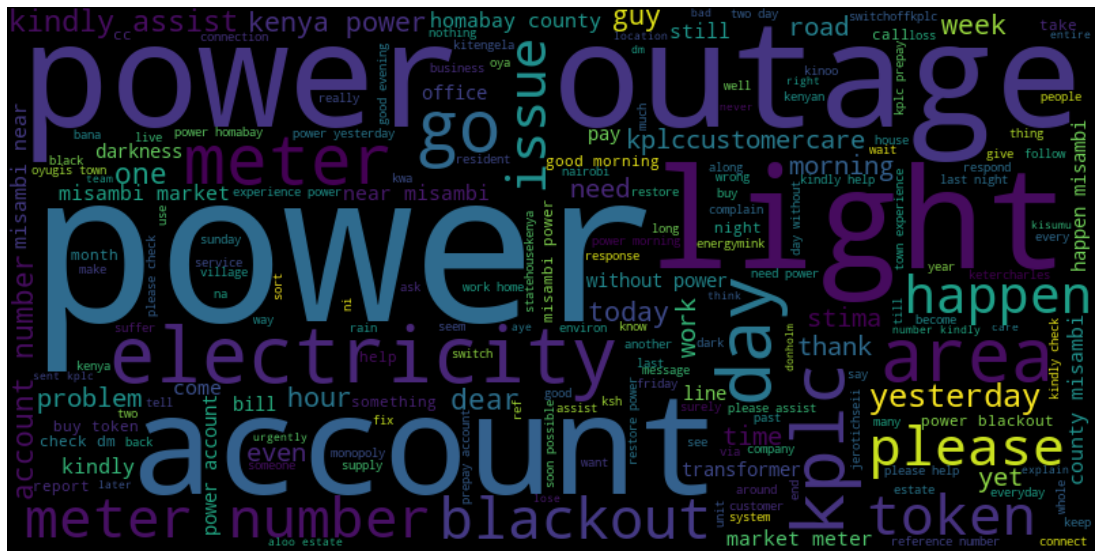

In [142]:
#let's see a word cloud of the most common terms
from wordcloud import WordCloud, ImageColorGenerator

text = df_english['lemmatized_joined'].tolist() 


text = ' '.join(text)


wordcloud = WordCloud(collocations=True,width=800, height=400).generate(text)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

### From the word cloud we realize that some of the words are repeated many times and is worth investigation to see whether it is a sign of dirty data.

In [143]:
#checking the most common words

fig =px.bar(get_top_n_words(df_english['lemmatized_joined'],1,50),x='words',y='count')
fig.show()

In [144]:
mostCommon = get_top_n_words(df_english['lemmatized_joined'],1,150)
indexes = []
for word in mostCommon['words']:
  sentences = df_english[df_english['lemmatized_joined'].str.contains(word)]
  if(sentences['handle'].nunique()/len(sentences) * 100 < 10):
    users = sentences['handle'].unique();
    for user in users:
      indexes += (df_english[df_english['lemmatized_joined'].str.contains(word) & df_english['handle'].str.contains(user)][1:].index.tolist())
indexes = list(dict.fromkeys(indexes))
df_english.drop(indexes,inplace=True)


In [145]:
fig =px.bar(get_top_n_words(df_english['lemmatized_joined'],1,50),x='words',y='count')
fig.show()

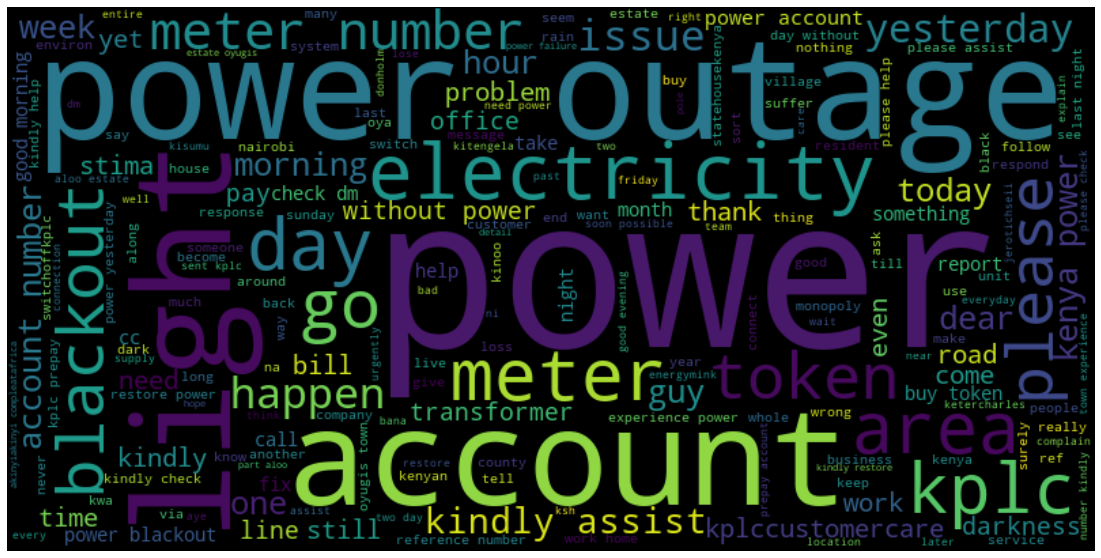

In [146]:
text = df_english['lemmatized_joined'].tolist() 


text = ' '.join(text)


wordcloud = WordCloud(collocations=True,width=800, height=400).generate(text)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

### Lets do some topic modeling on this data to check whether we could be able to categorize the tweets.

### We will start by trying LSA technique to see if we get sensible topics

In [147]:
vectorizer = TfidfVectorizer(
    max_df=0.8,
    ngram_range=(1,3),
    stop_words='english',
    max_features=100
    )

vectors = vectorizer.fit_transform(df_english['lemmatized_joined'])

In [148]:
lsa = TruncatedSVD(n_components=2,n_iter=1000)

lsa.fit(vectors)

TruncatedSVD(n_iter=1000)

In [149]:
vocabulary = vectorizer.get_feature_names_out()

for i, vect in enumerate(lsa.components_):
  voc_vect = zip(vocabulary,vect)
  sorted_voc = sorted(voc_vect,key = lambda x:x[1], reverse=True)[:15]
  print("Topic %d" % i)
  for term in sorted_voc:
    print(term[0])
  print(" ")

Topic 0
power
account
outage
power outage
kindly
area
day
meter
number
assist
blackout
yesterday
light
meter number
power account
 
Topic 1
light
token
meter
kindly
number
account
electricity
assist
kindly assist
meter number
kplc
blackout
morning
account number
buy
 


In [150]:
cluster_model = KMeans(n_clusters=2, max_iter=100,n_init=4)

cluster_model.fit(vectors)

clusters = cluster_model.predict(vectors)

pca = PCA(n_components=2)

scatter_plots = pca.fit_transform(vectors.toarray())

colors = ["topic 1","topic 2","topic 3"]

x_axis = [o[0] for o in scatter_plots]
y_axis = [o[1] for o in scatter_plots]

fig = px.scatter(x= x_axis, y = y_axis, color = [colors[d] for d in clusters])
fig.show()

In [151]:
clustersProb = cluster_model.cluster_centers_.argsort()[:,::-1]

for index_cluster in range(2):
  print("Topic %d" % index_cluster)
  for ind in clustersProb[index_cluster,:15]:
    print(vocabulary[ind])
  print(" ")

Topic 0
light
electricity
token
kindly
blackout
account
kplc
meter
stima
day
number
issue
area
morning
assist
 
Topic 1
power
outage
power outage
account
area
day
meter
number
power account
kenya
kindly
kenya power
happen
restore
yesterday
 


### From LSA we can clearly tell that we have 2 main categories for tweet queries:

1. Power outage.

2. Token Enquries.

### Lets now do an analysis using LDA to see if we are going to get more insightful data. 

In [156]:

textTokenized = df_english['lemmatized_joined'].apply(word_tokenize)
# Build the bigram and trigram models
bigram = gensim.models.Phrases(textTokenized, min_count=5, threshold=100) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

textP = make_bigrams(textTokenized)

id2word = corpora.Dictionary(textP)

corpus = [id2word.doc2bow(text) for text in textP]

tfidf = TfidfModel(corpus,id2word)

max_df = 0.03
words = []
words_missing = []
for i in range (0, len(corpus)):
  bow = corpus[i]
  low_value_words = []
  tfidf_ids = [id for id, value in tfidf[bow]]
  bow_ids = [id for id,value in bow]
  low_value_words = [id for id, value in tfidf[bow] if value < max_df]
  drops = low_value_words + words_missing
  for item in drops:
    words.append(id2word[item])
  words_missing = [id for id in bow_ids if id not in tfidf_ids]
  new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing]
  corpus[i] = new_bow


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [157]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [158]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus,id2word,mds="mmds", R=30)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.051757  0.163383       1        1  66.575436
0      0.051757 -0.163383       2        1  33.424564, topic_info=        Term         Freq        Total Category  logprob  loglift
30     power  1142.000000  1142.000000  Default  30.0000  30.0000
117     kplc   224.000000   224.000000  Default  29.0000  29.0000
505    token   192.000000   192.000000  Default  28.0000  28.0000
49     since   416.000000   416.000000  Default  27.0000  27.0000
329   kindly   329.000000   329.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
43     kenya    47.844617   115.752474   Topic2  -5.3830   0.2124
28       one    31.964436    95.011067   Topic2  -5.7864   0.0065
40   account    34.942336   377.322719   Topic2  -5.6973  -1.2835
342    stima    30.244320    62.151923   Topic2  -5.8417   0.3756
357     time    30.197144    63.859779   Topic2  -5.8432   0.3469

[117 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
2850      2  0.995040  54603705580_akinyiakinyi
40        1  0.906386                   account
40        2  0.092759                   account
72        1  0.997010                      area
517       1  0.996724                    assist
...     ...       ...                       ...
336       2  0.009396                      work
326       1  0.998753                 yesterday
326       2  0.005428                 yesterday
215       1  0.050178                       yet
215       2  0.940845                       yet

[151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [159]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=textTokenized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.671636079247486

Coherence Score:  0.27699830307638346
